## Identifying Duplicate Questions

Over 100 million people visit *Quora* every month, so it's no surprise that many people ask similar (or the same) questions. Various questions with the same intent can cause people to spend extra time searching for the best answer to their question, and results in members answering multiple versions of the same question. *Quora* uses random forest to identify duplicated questions to provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.

Follow the steps outlined below to build the appropriate classifier model. 

Steps:
- Download or load the data
- Exploration (EDA)
- Cleaning
- Feature Engineering
- Modeling

By the end of this project you should have **a presentation that describes the model you built** and its **performance**. 

### Step 1: Loading the data

In [2]:
# Import basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split

In [3]:
# Load "Quora" dataset
df = pd.read_csv("/Users/rafaelaqueiroz/Mini-Project-V/train.csv")
df.head(10)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
6,6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
8,8,17,18,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0
9,9,19,20,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,0


### Note
There is no designated test.csv file. The train.csv file is the entire dataset. Part of the data in the train.csv file should be set aside to act as the final testing data.

### Step 2: Exploration of the data

In [4]:
# Check the general information of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [5]:
# Check the number of rows and columns of the dataset
df.shape

(404290, 6)

The dataset has 6 columns and 404,290 rows in total.

In [6]:
# Check for missing or NaN values
df.isnull() # It returns a boolean df indicating the presence or absence of missing values in each cell of it

,id,qid1,qid2,question1,question2,is_duplicate
0,False,False,False,False,False,False
1,False,False,False,False,False,False
2,False,False,False,False,False,False
3,False,False,False,False,False,False
4,False,False,False,False,False,False
...,...,...,...,...,...,...
404285,False,False,False,False,False,False
404286,False,False,False,False,False,False
404287,False,False,False,False,False,False
404288,False,False,False,False,False,False


In [7]:
# Check for the total missing or NaN values
df.isnull().sum() # It sums up the number of 'True' values for each column

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [8]:
# Investigate the 3 rows that have the missing values
df[df.isnull().any(axis=1)]

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


Even though the first 2 rows have questions that are not marked as duplicates, they are semantically similar and produce the same pragmatic meaning. This is an important point to consider when building a model to identify duplicate questions, as it highlights the need to use NLP techniques that can capture the semantic similarity between questions, beyond just comparing the text directly.

Also, as we only have 3 NaN values, we decided to drop them as this represents a small percentage of duplicates in comparison with our total data. However, if this would represent a bigger percentage, the act of dropping rows would be needed to consider with caution as this could introduce bias to our dataset and affect the overall performance of our model. 

In [9]:
# Drop the missing values from the dataset
df.dropna(subset=['question1', 'question2'], inplace=True)

In [10]:
# Check for duplicate values before moving forward to our cleaning and preprocessing data
df_counts = df['is_duplicate'].value_counts() # It counts de number of duplicate and non-duplicate questions in the dataset
df_counts

0    255024
1    149263
Name: is_duplicate, dtype: int64

In [11]:
# Check the duplicate counts in terms of each percentage ("question1" and "question2") from the total
percentages = df_counts / len(df) * 100
percentages

0    63.079941
1    36.920059
Name: is_duplicate, dtype: float64

Now, let's visualize the percentage of each data to see its proportionality in 2 different graphs as this will help us to understand the impact of the amount of duplicates of *question 1* in comparison with *question 2*, considering the total number of the questions.

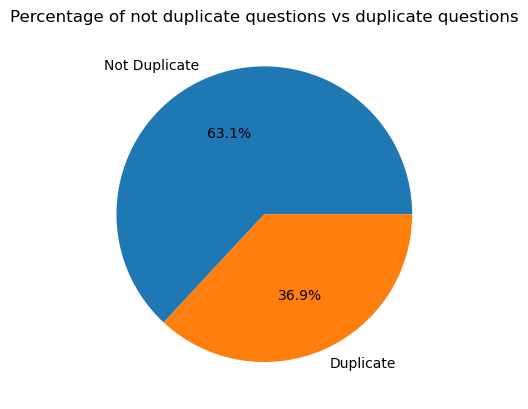

In [12]:
# Plot as a pie chart
labels = ['Not Duplicate', 'Duplicate']
plt.pie(percentages, labels=labels, autopct='%1.1f%%') 
plt.title('Percentage of not duplicate questions vs duplicate questions')
plt.show()

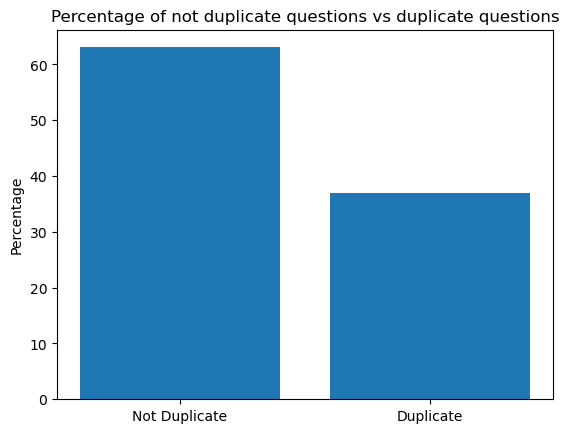

In [13]:
# Plot as a bar chart
plt.bar(labels, percentages)
plt.title('Percentage of not duplicate questions vs duplicate questions')
plt.ylabel('Percentage')
plt.show()

There are 255,024 non-duplicate questions and 149,263 duplicate questions in the dataframe. This is an important factor to be considered before making our model as the count of non-duplicate and duplicate questions can help us to understand the nature of the dataset and, likewise, to give us some information on how to approach a model to identify duplicate questions.

In our case, the number of duplicate questions (given by the Boolean 1) is much smaller than the number of non-duplicate questions. Then this could indicate that the dataset is imbalanced, which may affect the performance of the model afterwards. Thus, we might need to employ techniques like undersampling or oversampling to balance the dataset.

As this can pose a challenge when building a model - the model may be biased towards classifying questions as non-duplicates, leading to a poor performance on identifying duplicates -, we decided to address this balance with the use of undersampling.

In [14]:
# Select randomly a subset of non-duplicate questions to match the number of duplicate questions
duplicates = df[df['is_duplicate'] == 1] # Separate the duplicate and non-duplicate questions
non_duplicates = df[df['is_duplicate'] == 0]
num_duplicates = len(duplicates) # Get the number of duplicate questions
non_duplicates_sampled = non_duplicates.sample(num_duplicates) # Select a subset of non-duplicate questions

# Combine the sampled non-duplicate questions with the original duplicate questions
balanced_df = pd.concat([duplicates, non_duplicates_sampled], axis=0) 

# Shuffle the dataset to ensure that the duplicate and non-duplicate questions are mixed
balanced_df = balanced_df.sample(frac=1).reset_index(drop=True)
balanced_df

,id,qid1,qid2,question1,question2,is_duplicate
0,138496,220506,220507,Why don't we celebrate Columbus Day?,How should one celebrate Columbus Day?,0
1,160421,42810,42017,What is actual meaning of life?,What is the meanings of life?,1
2,368759,499167,499168,What incident gave you goosebumps?,Which incident gave you Goosebumps?,1
3,332533,438634,108799,Which book is the best book for algorithm and ...,What are the best algorithm books for beginners?,1
4,168157,36387,25096,How do I change my interests and likes on Quora?,How do I change my interests on Quora?,1
...,...,...,...,...,...,...
298521,99539,53820,165234,Where can I buy Cannabis Oil in the UK?,What's the best brand of olive oil I can buy i...,0
298522,360730,490529,490530,How much time is required for CAT preparations?,How much time is required for CAT preparation?,1
298523,161972,252243,96132,What qualities should you look for when decidi...,What makes you decide to follow someone on Quora?,1
298524,198688,299984,299985,Which is better? Washing powder or liquid dete...,Is liquid detergent better or powder detergent...,1


In [15]:
# Now, let's check if our dataset is more balanced
balanced_df['is_duplicate'].value_counts()

0    149263
1    149263
Name: is_duplicate, dtype: int64

#### 2.1 Splitting the dataset

In [16]:
# Split the dataset into X and y variables
X = balanced_df[['question1', 'question2']]
y = balanced_df['is_duplicate']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1000)

In [17]:
# Check the format of the dataset trainning sets
print(X_train.shape)
print(y_train.shape)

(238820, 2)
(238820,)


In [18]:
# Check the format of the dataset testing sets
print(X_test.shape)
print(y_test.shape)

(59706, 2)
(59706,)


In [19]:
# Check the features of X_train 
X_train.head()

,question1,question2
27971,Is there a possibility to love 2 person at once?,Is it possible for people to love 2 person at ...
39167,How can you register a dog without papers (AKC)?,How can I register a purebred dog without papers?
134599,What is the best phone under 10k in India?,Which is best phone under 10000?
154421,If you could only eat one food for the rest of...,What would happen if you eat the same food for...
51181,What's the best photo you have taken on an iPh...,What are the best photos you have taken by Mob...


After splitting our dataset, we are going to use only the trainning set to be cleaned, analyzed and enginnered whereas the testing set is going to be separated aside to be used solemnly in the testing of our model as a recommended practice in data science.

It's important to keep the testing dataset separated from the training dataset to avoid overfitting, which occurs when a model performs very well on the training data but very poor on the testing data. By using the training dataset only, we can create a better model that is more likely to perform well on unseen data.

### Step 3: Cleaning

- Removing punctuation
- Tokenization
- Cleaning stopwords
- Normalizing
- Stemming or Lemmitization

In order to clean and preprocess the text data, we are going to apply different techniques, such as, converting it to lowercase, removing stop words and punctuation, and stemming or lemmatization of the the words.

#### Removing punctuation

In [20]:
# Import more libraries
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [21]:
# Define a function to remove punctuation in our "question1" and "question2" columns
def remove_punct(text):
    text = "".join([char for char in text if char not in string.punctuation])
    return text

X_train = X_train.assign( # Assigning the new 2 columns in the dataframe
    question1_cleaned=X_train["question1"].apply(remove_punct),
    question2_cleaned=X_train["question2"].apply(remove_punct)
)

X_train.tail(2)

,question1,question2,question1_cleaned,question2_cleaned
71751,When did the trend of writing biographies on o...,"What is the difference between wit, humor and ...",When did the trend of writing biographies on o...,What is the difference between wit humor and s...
107955,What is it like to be hunted by the FBI?,What does it feel like to be hunted by the FBI?,What is it like to be hunted by the FBI,What does it feel like to be hunted by the FBI


In [22]:
# Drop the columns that are not going to be used anymore
X_train = X_train.drop(['question1', 'question2'], axis=1)
X_train.tail(2)

,question1_cleaned,question2_cleaned
71751,When did the trend of writing biographies on o...,What is the difference between wit humor and s...
107955,What is it like to be hunted by the FBI,What does it feel like to be hunted by the FBI


#### Tokenization and applying lower case

In [23]:
# Import regular expression library
import re

In [24]:
# Define a function to split our sentences into a list of words
def tokenize(text):
    tokens = text.split()
    return tokens

X_train['question_1_tokenized'] = X_train['question1_cleaned'].apply(lambda x: tokenize(x.lower()))
X_train['question_2_tokenized'] = X_train['question2_cleaned'].apply(lambda x: tokenize(x.lower()))
X_train.tail(2)

,question1_cleaned,question2_cleaned,question_1_tokenized,question_2_tokenized
71751,When did the trend of writing biographies on o...,What is the difference between wit humor and s...,"[when, did, the, trend, of, writing, biographi...","[what, is, the, difference, between, wit, humo..."
107955,What is it like to be hunted by the FBI,What does it feel like to be hunted by the FBI,"[what, is, it, like, to, be, hunted, by, the, ...","[what, does, it, feel, like, to, be, hunted, b..."


In [25]:
# Drop the previous columns
X_train = X_train.drop(['question1_cleaned', 'question2_cleaned'], axis=1)
X_train.tail(2)

,question_1_tokenized,question_2_tokenized
71751,"[when, did, the, trend, of, writing, biographi...","[what, is, the, difference, between, wit, humo..."
107955,"[what, is, it, like, to, be, hunted, by, the, ...","[what, does, it, feel, like, to, be, hunted, b..."


#### Cleaning the stopwords

In [26]:
# Import the NLTK package
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# View the stopwords
ENGstopwords = stopwords.words('english')
ENGstopwords[0:25]

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rafaelaqueiroz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers']

In [27]:
# Define a function to remove stopwords
def remove_stopwords(tokenized_text):    
    text = [word for word in tokenized_text if word not in ENGstopwords]
    return text

X_train['question1_non_stop'] = X_train['question_1_tokenized'].apply(lambda x: remove_stopwords(x))
X_train['question2_non_stop'] = X_train['question_2_tokenized'].apply(lambda x: remove_stopwords(x))
X_train.tail(2)

,question_1_tokenized,question_2_tokenized,question1_non_stop,question2_non_stop
71751,"[when, did, the, trend, of, writing, biographi...","[what, is, the, difference, between, wit, humo...","[trend, writing, biographies, online, profiles...","[difference, wit, humor, sarcasm]"
107955,"[what, is, it, like, to, be, hunted, by, the, ...","[what, does, it, feel, like, to, be, hunted, b...","[like, hunted, fbi]","[feel, like, hunted, fbi]"


In [28]:
# Drop the previous columns
X_train = X_train.drop(['question_1_tokenized', 'question_2_tokenized'], axis=1)
X_train.tail(2)

,question1_non_stop,question2_non_stop
71751,"[trend, writing, biographies, online, profiles...","[difference, wit, humor, sarcasm]"
107955,"[like, hunted, fbi]","[feel, like, hunted, fbi]"


#### Stemming

In [29]:
# Import modules 
nltk.download('punkt')
from nltk.stem import PorterStemmer

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/rafaelaqueiroz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [30]:
# Create a stemmer object
ps = PorterStemmer() # It will remove pre-defined stems

# Define a function to stem the text
def stemmed_text(words):
    stemmed_words = [] # It initializes a new variable list
    for word in words:
        stemmed_words.append(ps.stem(word))
    return stemmed_words

In [31]:
# Call up the function that applies "stemmed_text" to our columns in the data frame
X_train['question1_stem'] = X_train['question1_non_stop'].apply(lambda x: stemmed_text(x))
X_train['question2_stem'] = X_train['question2_non_stop'].apply(lambda x: stemmed_text(x))
X_train.tail(2)

,question1_non_stop,question2_non_stop,question1_stem,question2_stem
71751,"[trend, writing, biographies, online, profiles...","[difference, wit, humor, sarcasm]","[trend, write, biographi, onlin, profil, bulle...","[differ, wit, humor, sarcasm]"
107955,"[like, hunted, fbi]","[feel, like, hunted, fbi]","[like, hunt, fbi]","[feel, like, hunt, fbi]"


Before dropping the previous columns, we are going to make a comparative of the modification results given by stemming with the ones given by lemmatization technique.

#### Lemmatization

In [32]:
# Importing some modules 
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/rafaelaqueiroz/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/rafaelaqueiroz/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [33]:
# Create a lemmatizer object
lemmatizer = WordNetLemmatizer() 

# Create a function to apply lemmitization into our words
def lemmitization(words):
    lemmitization_words = []
    for word in words:
        lemmitization_list = ' '.join([lemmatizer.lemmatize(word) for word in words])
        lemmitization_words.append(lemmitization_list)
    return lemmitization_words 

In [34]:
# Call up the function that applies lemmatization to our columns in the data frame
X_train['question1_lemm'] = X_train['question1_non_stop'].apply(lambda x: stemmed_text(x))
X_train['question2_lemm'] = X_train['question2_non_stop'].apply(lambda x: stemmed_text(x))
X_train.tail(2)

,question1_non_stop,question2_non_stop,question1_stem,question2_stem,question1_lemm,question2_lemm
71751,"[trend, writing, biographies, online, profiles...","[difference, wit, humor, sarcasm]","[trend, write, biographi, onlin, profil, bulle...","[differ, wit, humor, sarcasm]","[trend, write, biographi, onlin, profil, bulle...","[differ, wit, humor, sarcasm]"
107955,"[like, hunted, fbi]","[feel, like, hunted, fbi]","[like, hunt, fbi]","[feel, like, hunt, fbi]","[like, hunt, fbi]","[feel, like, hunt, fbi]"


In [35]:
# Drop previous columns and staying with the lemmatization technique
X_train = X_train.drop(['question1_non_stop', 'question2_non_stop', 'question1_stem', 'question2_stem'], axis=1)
X_train.tail(2)

,question1_lemm,question2_lemm
71751,"[trend, write, biographi, onlin, profil, bulle...","[differ, wit, humor, sarcasm]"
107955,"[like, hunt, fbi]","[feel, like, hunt, fbi]"


### Step 4: Feature Engineering

- tf-idf
- word count
- word2vec
- number of the same words in both questions
- ....

At this step, we are going to extract relevant features from the preprocessed text data. Some useful features for this task might include the length of the questions, the cosine similarity between their vector representations (WordCount), and the number of shared words between questions as belonging to the same semantic field (Word2Vec).

#### Calculating the length of the questions

In [36]:
# Define a function to calculate the length of a string
def calculate_length(text):
    return len(str(text))

# Create a new dataframe with the columns 'q1_lemm_len' and 'q2_lemm_len'
X_train_len = pd.DataFrame()

# Apply the function to each element in the 'question1_lemm' and 'question2_lemm' columns
X_train_len['q1_lemm_len'] = X_train['question1_lemm'].apply(calculate_length)
X_train_len['q2_lemm_len'] = X_train['question2_lemm'].apply(calculate_length)
X_train_len.head(10)


,q1_lemm_len,q2_lemm_len
27971,34,51
39167,44,47
134599,33,26
154421,65,50
51181,64,35
122319,41,76
154407,41,66
36506,39,66
179413,37,55
177051,39,112


In [37]:
X_train.head(10)

,question1_lemm,question2_lemm
27971,"[possibl, love, 2, person]","[possibl, peopl, love, 2, person, time]"
39167,"[regist, dog, without, paper, akc]","[regist, purebr, dog, without, paper]"
134599,"[best, phone, 10k, india]","[best, phone, 10000]"
154421,"[could, eat, one, food, rest, life, would, choos]","[would, happen, eat, food, rest, life]"
51181,"[what, best, photo, taken, iphoneandroid, smar...","[best, photo, taken, mobil]"
122319,"[intend, mental, health, america]","[base, famili, experi, think, improv, health, ..."
154407,"[safe, clean, flat, screen, tv]","[touch, tv, screen, affect, tv, clean, tv, aff..."
36506,"[get, neighbor, wifi, password]","[chang, wifi, admin, password, forgotten, get,..."
179413,"[debunk, flat, earth, theori]","[debunk, argument, use, flat, earth, advoc]"
177051,"[would, keep, tag, line, ipl]","[indian, premier, leagu, ipl, best, play, xi, ..."


From this quick exploration, we can notice that most of the questions have the same length (the same number of words) with only some exceptions (for example, the paired up questions of index 39167). This is a factor to be considered as this can impact the model in identifying duplicate questions from the users.

#### WordCount

This algorithm is explored here in order to understand the frequency of the words used in a document and also the similarity between the vectors represented by the words used in the *question 1* and *question 2*. The cosine vector values range from -1 to 1 which is an indication of their similarity. 

The WordCount algorithm can be used to calculate the frequency of words in a document, and it can also be used to represent each document as a vector of word frequencies. These vectors can be compared using various similarity measures, such as the cosine similarity, to assess the similarity between two documents.

In the context of comparing the question 1 and question 2 columns of a dataset, the WordCount algorithm could be used to calculate the frequency of words in each question and represent them as vectors of word frequencies. Then, the cosine similarity between the two vectors could be calculated to determine the similarity between the two questions.

t is worth noting that while the WordCount algorithm is a useful tool for analyzing the frequency of words in a document, it does not capture the semantic meaning of the words or the context in which they are used. That is the reason why we explored our trainning dataset with the * Word2Vec*  algorithm afterwards.

In [38]:
# Import the module "CountVectorizer" from sklearn library
from sklearn.feature_extraction.text import CountVectorizer

In [39]:
# Check how many words we can find considering each feature and our trainning dataset
question1_wordcount = X_train['question1_lemm'].shape
print(question1_wordcount)
question2_wordcount = X_train['question2_lemm'].shape
print(question2_wordcount)

(238820,)
(238820,)


In [40]:
# Instantiate a CountVectorizer class object
countVectorizer = CountVectorizer(strip_accents=ascii, lowercase=False)

In [41]:
# Append the 2 sets of trainning data from each feature: "question1" and "question2"
X_train_final = X_train['question1_lemm'].append(X_train['question2_lemm'])
len(X_train_final)

/var/folders/zt/gl7xtkgj7238nsqq03s_q7840000gn/T/ipykernel_63686/3982557574.py:2: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train_final = X_train['question1_lemm'].append(X_train['question2_lemm'])


477640

##### Applying the *.fit()* and *.transform()* methods to the training dataset

In [42]:
# Fit the "X_train_final" dataset to the countVectorizer class object
train_countVectorizer = countVectorizer.fit(X_train_final)
train_countVectorizer

CountVectorizer(lowercase=False, strip_accents=<built-in function ascii>)

In [43]:
# Assign the transform method
X_train_question_1 = train_countVectorizer.transform(X_train['question1_lemm'])
print(X_train_question_1)

  (0, 31519)	1
  (0, 40266)	1
  (0, 41493)	1
  (1, 5284)	1
  (1, 17132)	1
  (1, 39410)	1
  (1, 44193)	1
  (1, 58799)	1
  (2, 320)	1
  (2, 8849)	1
  (2, 26656)	1
  (2, 40535)	1
  (3, 12499)	1
  (3, 14272)	1
  (3, 18010)	1
  (3, 21076)	1
  (3, 30900)	1
  (3, 38282)	1
  (3, 44615)	1
  (3, 59034)	1
  (4, 8849)	1
  (4, 27490)	1
  (4, 40572)	1
  (4, 48548)	1
  (4, 51267)	1
  :	:
  (238815, 30215)	1
  (238815, 35199)	1
  (238816, 5597)	1
  (238816, 8849)	1
  (238816, 10885)	1
  (238816, 11315)	1
  (238816, 13438)	1
  (238816, 14358)	1
  (238816, 18893)	1
  (238816, 51264)	1
  (238817, 1577)	1
  (238817, 29969)	1
  (238817, 51003)	1
  (238818, 9272)	1
  (238818, 10599)	1
  (238818, 17301)	1
  (238818, 38359)	1
  (238818, 41185)	1
  (238818, 42255)	1
  (238818, 49746)	1
  (238818, 53277)	1
  (238818, 59091)	1
  (238819, 20254)	1
  (238819, 25648)	1
  (238819, 30987)	1


In [44]:
# Assign the transform method to the "question 2" feature of the X_train
X_train_question_2 = train_countVectorizer.transform(X_train['question2_lemm'])
print(X_train_question_2)

  (0, 31519)	1
  (0, 40102)	1
  (0, 40266)	1
  (0, 41493)	1
  (0, 52517)	1
  (1, 17132)	1
  (1, 39410)	1
  (1, 42801)	1
  (1, 44193)	1
  (1, 58799)	1
  (2, 141)	1
  (2, 8849)	1
  (2, 40535)	1
  (3, 18010)	1
  (3, 21076)	1
  (3, 24065)	1
  (3, 30900)	1
  (3, 44615)	1
  (3, 59034)	1
  (4, 8849)	1
  (4, 34669)	1
  (4, 40572)	1
  (4, 51267)	1
  (5, 5768)	1
  (5, 8307)	1
  :	:
  (238813, 42277)	1
  (238814, 31479)	1
  (238814, 43169)	1
  (238814, 58246)	1
  (238815, 8849)	1
  (238815, 19462)	1
  (238815, 35199)	1
  (238815, 46851)	1
  (238816, 5597)	1
  (238816, 10885)	1
  (238816, 14358)	2
  (238816, 35656)	1
  (238816, 51267)	1
  (238817, 1577)	1
  (238817, 29969)	1
  (238817, 50118)	1
  (238817, 51003)	1
  (238818, 16566)	1
  (238818, 25622)	1
  (238818, 46102)	1
  (238818, 58777)	1
  (238819, 20254)	1
  (238819, 20326)	1
  (238819, 25648)	1
  (238819, 30987)	1


In [45]:
# Convert "X_train_question_1" to an array
X_train_question_1[0].toarray()

array([[0, 0, 0, ..., 0, 0, 0]])

In [46]:
# Convert "X_train_question_2" to an array
X_train_question_2[0].toarray()

array([[0, 0, 0, ..., 0, 0, 0]])

In [47]:
# Make a specific dataframe for each feature separately
X_train_question1_word_count = pd.DataFrame(X_train_question_1, columns=['question1_word_count'])
X_train_question1_word_count.tail(2)

,question1_word_count
238818,"(0, 9272)\t1\n (0, 10599)\t1\n (0, 17301)\..."
238819,"(0, 20254)\t1\n (0, 25648)\t1\n (0, 30987)\t1"


In [48]:
# Make a specific dataframe for each feature separately
X_train_question2_word_count = pd.DataFrame(X_train_question_2, columns=['question2_word_count'])
X_train_question2_word_count.tail(2)

,question2_word_count
238818,"(0, 16566)\t1\n (0, 25622)\t1\n (0, 46102)..."
238819,"(0, 20254)\t1\n (0, 20326)\t1\n (0, 25648)..."


In [49]:
# Join the 2 dataframes together
X_train_q1_and_q2_word_count = pd.concat([X_train_question1_word_count, X_train_question2_word_count], axis=1)
X_train_q1_and_q2_word_count.tail(2)

,question1_word_count,question2_word_count
238818,"(0, 9272)\t1\n (0, 10599)\t1\n (0, 17301)\...","(0, 16566)\t1\n (0, 25622)\t1\n (0, 46102)..."
238819,"(0, 20254)\t1\n (0, 25648)\t1\n (0, 30987)\t1","(0, 20254)\t1\n (0, 20326)\t1\n (0, 25648)..."


##### Applying the *.transform()* method to the test dataset

In [50]:
# Assign the transform method to our test dataset
X_test_question_1 = countVectorizer.transform(X_test['question1'])
print(X_test_question_1)

  (0, 8488)	1
  (0, 11108)	1
  (0, 12430)	2
  (0, 21754)	1
  (0, 30987)	1
  (0, 38569)	1
  (0, 40182)	1
  (0, 48003)	1
  (0, 52140)	1
  (0, 52691)	1
  (0, 58462)	1
  (1, 4665)	1
  (1, 17062)	1
  (1, 38264)	1
  (1, 41498)	1
  (1, 52691)	1
  (1, 60157)	1
  (2, 8849)	1
  (2, 26494)	1
  (2, 26656)	1
  (2, 27203)	1
  (2, 38569)	1
  (2, 52059)	1
  (3, 6177)	1
  (3, 11108)	1
  :	:
  (59701, 52140)	1
  (59701, 52691)	1
  (59701, 58783)	1
  (59702, 22471)	1
  (59702, 24769)	1
  (59702, 26117)	1
  (59702, 26494)	1
  (59702, 45216)	1
  (59702, 48930)	1
  (59702, 52045)	1
  (59702, 57834)	1
  (59702, 58225)	1
  (59702, 60157)	2
  (59703, 12833)	1
  (59703, 22969)	1
  (59703, 26494)	1
  (59704, 9552)	1
  (59704, 11864)	1
  (59704, 26494)	1
  (59704, 38264)	1
  (59704, 52140)	1
  (59704, 52691)	1
  (59704, 58059)	1
  (59705, 33620)	1
  (59705, 52691)	1


In [51]:
# Assign the transform method to our "question 2" feature of the X_test dataset 
X_test_question_2 = countVectorizer.transform(X_test['question2'])
print(X_test_question_2)

  (0, 4945)	1
  (0, 5979)	1
  (0, 7213)	1
  (0, 17062)	1
  (0, 17115)	1
  (0, 22471)	1
  (0, 24065)	1
  (0, 25402)	1
  (0, 27763)	1
  (0, 33496)	1
  (0, 38018)	1
  (0, 48930)	1
  (0, 48942)	1
  (0, 52691)	1
  (0, 58783)	1
  (1, 17062)	1
  (1, 21618)	1
  (1, 52691)	1
  (1, 56439)	1
  (1, 60157)	1
  (1, 60177)	2
  (2, 22969)	1
  (2, 38569)	1
  (3, 17062)	1
  (3, 26471)	1
  :	:
  (59701, 49944)	1
  (59701, 52045)	1
  (59702, 5979)	1
  (59702, 10384)	1
  (59702, 11108)	1
  (59702, 22471)	1
  (59702, 24769)	1
  (59702, 26494)	2
  (59702, 35723)	1
  (59702, 45216)	1
  (59702, 57834)	1
  (59702, 58225)	1
  (59703, 8849)	1
  (59703, 12833)	1
  (59703, 26494)	1
  (59703, 52059)	1
  (59704, 9552)	1
  (59704, 11108)	1
  (59704, 38264)	1
  (59704, 58189)	1
  (59705, 11108)	1
  (59705, 26117)	1
  (59705, 26440)	1
  (59705, 27763)	1
  (59705, 33620)	1


In [52]:
# Convert "X_test_question_1" to an array
X_test_question_1[0].toarray()

array([[0, 0, 0, ..., 0, 0, 0]])

In [53]:
# Convert "X_test_question_2" to an array
X_test_question_2[0].toarray()

array([[0, 0, 0, ..., 0, 0, 0]])

In [54]:
# Make a specific dataframe for each feature separately
X_test_question_1_vect = pd.DataFrame(X_test_question_1, columns=['question1_vect'])
X_test_question_1_vect.tail(2)

,question1_vect
59704,"(0, 9552)\t1\n (0, 11864)\t1\n (0, 26494)\..."
59705,"(0, 33620)\t1\n (0, 52691)\t1"


In [55]:
# Make a specific dataframe for each feature separately
X_test_question_2_vect = pd.DataFrame(X_test_question_2, columns=['question2_vect'])
X_test_question_2_vect.tail(2)

,question2_vect
59704,"(0, 9552)\t1\n (0, 11108)\t1\n (0, 38264)\..."
59705,"(0, 11108)\t1\n (0, 26117)\t1\n (0, 26440)..."


In [56]:
# Join the 2 dataframes together
X_test_q1_and_q2_vect = pd.concat([X_test_question_1_vect, X_test_question_2_vect], axis=1)
X_test_q1_and_q2_vect.tail(2)

,question1_vect,question2_vect
59704,"(0, 9552)\t1\n (0, 11864)\t1\n (0, 26494)\...","(0, 9552)\t1\n (0, 11108)\t1\n (0, 38264)\..."
59705,"(0, 33620)\t1\n (0, 52691)\t1","(0, 11108)\t1\n (0, 26117)\t1\n (0, 26440)..."


In [57]:
# Check the type of our dataset to make sure they are the same type before doing the test of the algorithm
print(type(X_train_q1_and_q2_word_count))
print(type(X_test_q1_and_q2_vect))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [58]:
X_train_q1_and_q2_word_count.shape

(238820, 2)

In [59]:
X_train_q1_and_q2_word_count.columns

Index(['question1_word_count', 'question2_word_count'], dtype='object')

In [60]:
X_test_q1_and_q2_vect.shape

(59706, 2)

In [61]:
X_test_q1_and_q2_vect.columns

Index(['question1_vect', 'question2_vect'], dtype='object')

In [62]:
# Import the module "cosine_similarity from sklearn"
from sklearn.metrics.pairwise import cosine_similarity

In [63]:
# Create a function to iterate through each row of the dataframe to get the "cosine_similarities" of the questions 1 and 2 from my X_train
train_count_cosine = []
for row in range(len(X_train_q1_and_q2_word_count)):
    train_count_cosine.append(cosine_similarity(X_train_q1_and_q2_word_count['question1_word_count'][row], X_train_q1_and_q2_word_count['question2_word_count'][row]))

In [64]:
# Reshape the "train_count_cosine" list created above so we can convert it in a new dataframe
train_count_cosine = np.reshape(train_count_cosine, (238820, 1))
train_count_cosine.shape

(238820, 1)

In [65]:
print(train_count_cosine)

[[0.77459667]
 [0.8       ]
 [0.57735027]
 ...
 [0.8660254 ]
 [0.        ]
 [0.8660254 ]]


In [66]:
# Create a dataframe from list "train_count_cosine"
train_cosine_df = pd.DataFrame(train_count_cosine, columns = ['train_cosine_similarity'])
train_cosine_df.head()

,train_cosine_similarity
0,0.774597
1,0.800000
2,0.577350
3,0.721688
4,0.612372


In [67]:
X_train.head()

,question1_lemm,question2_lemm
27971,"[possibl, love, 2, person]","[possibl, peopl, love, 2, person, time]"
39167,"[regist, dog, without, paper, akc]","[regist, purebr, dog, without, paper]"
134599,"[best, phone, 10k, india]","[best, phone, 10000]"
154421,"[could, eat, one, food, rest, life, would, choos]","[would, happen, eat, food, rest, life]"
51181,"[what, best, photo, taken, iphoneandroid, smar...","[best, photo, taken, mobil]"


The results in the *train_cosine_df* dataframe above compared with our preprocessed dataframe *X_train* represent the cosine similarity values between the pairs of questions 1 and 2 in the trainning set. The index of the dataframe corresponds to the index of the question pairs in the original dataset (in this case the *X_train*), and the value in each row represents the cosine similarity between the corresponding pair of questions; more especifically we calculated the cosine similarity between pairs of questions based on their word frequency counts.

Note: The cosine similarity is a metric that measures the similarity between two vectors in a high-dimensional space. A cosine similarity value of 1 indicates that the two questions are identical (for example, they have the exact same words and/or the exact same frequencies), while a value of 0 indicates that the two questions are not considered similar (for example, they have no words in common detected). Values between 0 and 1 indicate partial similarity, where higher values indicate greater similarity.

Now, let's apply this analysis to our test set.

In [68]:
# Create a function to iterate through each row of the dataframe to get the "cosine_similarities" of the questions 1 and 2 from my X_test
test_count_cosine = []
for row in range(len(X_test_q1_and_q2_vect)):
    test_count_cosine.append(cosine_similarity(X_test_q1_and_q2_vect['question1_vect'][row], X_test_q1_and_q2_vect['question2_vect'][row]))

In [69]:
# Reshape the "test_count_cosine" list created so we can also convert it in a new dataframe
test_count_cosine = np.reshape(test_count_cosine, (59706, 1))
test_count_cosine.shape

(59706, 1)

In [70]:
print(test_count_cosine)

[[0.06900656]
 [0.40824829]
 [0.28867513]
 ...
 [0.57735027]
 [0.37796447]
 [0.31622777]]


In [71]:
# Create a dataframe from list "test_count_cosine"
test_cosine_df = pd.DataFrame(test_count_cosine, columns = ['test_cosine_similarity'])
test_cosine_df.head()

,test_cosine_similarity
0,0.069007
1,0.408248
2,0.288675
3,0.516398
4,0.596285


In [72]:
X_test.head()

,question1,question2
146132,Are there biological chips or biological modul...,"If someone regularly yells at me, I get afraid..."
144980,How do you add a picture to a post on Reddit?,How do you upload pictures from your PC to you...
240112,Who is in the best interest for india? Hillary...,Who is good for India Hillary or Trump?
121127,How can I improve my answer writing skills in ...,How do I improve my writing skills for UPSC?
232148,Why do I feel lonely without friends?,"I don't have any friends and I feel lonely, wh..."


Again, here, we can notice the cosine similarity results applied to our testing data which gave us somewhat good results, but still might not good enough. For example, the cosine similarity of paired questions with index 240112 is 0.566 but as those questions are related and have similar pragmatic function, it could be higher. The value given represent that they were considered only partially similar, but indeed they are very closer to each other (in this case, probably the word *best* affected the result.)

#### Word2Vec

In [73]:
# Import gensim library and module
import gensim
from gensim.models import Word2Vec

In [74]:
# Instantiate Word2Vec object
word2vec_q1 = Word2Vec(X_train['question1_lemm'], window=5, min_count=2) # Window displays the size of window for surrounding words
word2vec_q2 = Word2Vec(X_train['question2_lemm'], window=5, min_count=2) # The min_count ignores all words that appear less than that
print(word2vec_q1)
print(word2vec_q2)

Word2Vec(vocab=22443, vector_size=100, alpha=0.025)
Word2Vec(vocab=20896, vector_size=100, alpha=0.025)


In [75]:
# Get the unique words that appear at least 2 times
question1_words = word2vec_q1.wv.index_to_key
question2_words = word2vec_q2.wv.index_to_key
print(question1_words)
print(question2_words)

['best', 'get', 'india', 'like', 'peopl', 'way', 'differ', 'use', 'good', 'would', 'make', 'quora', 'one', 'learn', 'life', 'time', 'money', 'question', 'know', 'what', 'work', 'indian', 'think', 'start', 'new', 'thing', 'trump', 'book', 'mean', 'year', 'note', 'someon', 'becom', 'engin', 'much', 'go', 'ever', 'movi', 'find', 'happen', 'mani', 'onlin', 'world', 'day', 'without', 'improv', 'us', 'job', 'english', 'person', 'better', 'want', 'feel', 'first', 'girl', 'love', '500', '1000', 'take', '2016', 'univers', 'need', 'possibl', 'prepar', 'program', 'account', 'compani', 'could', 'ask', 'weight', 'languag', 'donald', 'lose', 'phone', 'compar', 'number', 'buy', 'countri', 'answer', 'dont', 'stop', 'chang', 'realli', 'live', 'websit', 'import', 'presid', 'effect', 'googl', 'studi', 'war', 'student', 'black', 'busi', 'long', 'develop', 'sex', 'win', 'app', 'place', 'exampl', 'help', 'colleg', 'facebook', 'ban', 'increas', 'write', 'rupe', 'game', 'friend', 'market', 'clinton', 'rs', 'i

In [76]:
# Get similar word vector scores after choosing a word from the dictionary of "question1_words" above
question1_words_similar = word2vec_q1.wv.most_similar('best')
question1_words_similar

[('cheapest', 0.6944335699081421),
 ('good', 0.6650809645652771),
 ('fastest', 0.6444652080535889),
 ('safest', 0.6309980154037476),
 ('easiest', 0.630169689655304),
 ('easi', 0.5967341661453247),
 ('cheap', 0.5497035980224609),
 ('bookfinet', 0.5484988689422607),
 ('vaidya', 0.5424892902374268),
 ('compaq', 0.5422369837760925)]

In [77]:
# Get similar word vector scores after chosing a word from the dictionary of "question2_words" above
question2_words_similar = word2vec_q2.wv.most_similar('best')
question2_words_similar

[('good', 0.6858064532279968),
 ('easiest', 0.6207179427146912),
 ('cheapest', 0.6168699264526367),
 ('fastest', 0.6063467860221863),
 ('gallston', 0.5825764536857605),
 ('safest', 0.578444242477417),
 ('foremost', 0.5649168491363525),
 ('favorit', 0.5629751682281494),
 ('woocommerc', 0.5555997490882874),
 ('easi', 0.5476274490356445)]

From these results, we can notice that both question 1 and question 2 features retrieved bascially the same results. Also, the word *good* appears in the 1st and the 2nd place respectively, and mostly the idea of *best* is semantically represented by the concepts brough up of *velocity* and *price*. 

On the top of that, as there is a semantic association shown up by the weights of the vectors, it is noted that the antonyms are also brought up, such as: *crappi* and *unlink*.

In [78]:
# Get similar word vector scores after choosing a word from the dictionary of "question1_words" above
question1_words_similar = word2vec_q1.wv.most_similar('like')
question1_words_similar

[('genitalia', 0.510802686214447),
 ('appropri', 0.5003818869590759),
 ('parentchild', 0.4971235990524292),
 ('vulva', 0.49163463711738586),
 ('want', 0.4784104824066162),
 ('santorum', 0.47714075446128845),
 ('parsiszoroastrian', 0.47578728199005127),
 ('turmoil', 0.4740443229675293),
 ('goodlook', 0.46480050683021545),
 ('rather', 0.4642358422279358)]

In [79]:
# Get similar word vector scores after chosing a word from the dictionary of "question2_words" above
question2_words_similar = word2vec_q2.wv.most_similar('like')
question2_words_similar

[('asham', 0.5306775569915771),
 ('enviou', 0.5150339007377625),
 ('dissatisfi', 0.491330087184906),
 ('lone', 0.49006831645965576),
 ('hopper', 0.4893558919429779),
 ('handsomeattract', 0.48587456345558167),
 ('apathi', 0.4802264869213104),
 ('yeah', 0.47976818680763245),
 ('will', 0.4776107668876648),
 ('want', 0.4739980399608612)]

In regards of the second set of vector scores, it looks like that most of que words from the "question 1" dictionary evoke the idea of comparison (e.g. *appropri*, *forward*, *prefer*, *rather*) whereas the words from the dictionary of "question 2" bring out the idea or state of a quality (e.g. *dissatisfi*, *lone*, *apathi*, *uncomfort*, *coz*).

In addition, as we can see by this analysis, this algorithm is the only one which can retrieve the semantic association of a given *word* with other *words* and their surroundings, aspect that can contribute to understanding the context of the use of the words (semantic and pragmatic meaning together). Therefore, this is the algorithm chosen to be used in our modelling below.

### Step 5: Modeling

Different modeling techniques can be used:

- logistic regression
- XGBoost
- LSTMs
- etc

Choose a machine learning algorithm that is appropriate for this task, such as logistic regression, decision tree, random forest, or support vector machine. Split the data into training and testing sets, and train the model on the training data.

In [80]:
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)

X_train shape: (238820, 2)
y_train shape: (238820,)


In [81]:
X_train.head()

,question1_lemm,question2_lemm
27971,"[possibl, love, 2, person]","[possibl, peopl, love, 2, person, time]"
39167,"[regist, dog, without, paper, akc]","[regist, purebr, dog, without, paper]"
134599,"[best, phone, 10k, india]","[best, phone, 10000]"
154421,"[could, eat, one, food, rest, life, would, choos]","[would, happen, eat, food, rest, life]"
51181,"[what, best, photo, taken, iphoneandroid, smar...","[best, photo, taken, mobil]"


In [82]:
y_train.head()

27971     1
39167     1
134599    1
154421    1
51181     1
Name: is_duplicate, dtype: int64

In [83]:
# # Convert the dataframes to numpy arrays
# X_train = X_train.values
# y_train = y_train.values

In [95]:
# Import libraries
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

In [85]:
# Import the gensim library and its modules
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
model = Word2Vec(sentences=common_texts, vector_size=100, window=5, min_count=2, workers=4)
model.save("word2vec.model")

In [86]:
# Convert text to a word vector by creating a class object called "Word2VecVectorizer"
from sklearn.base import TransformerMixin # Import the module TransformerMixin

# Define the Word2VecVectorizer transformer class
class Word2VecVectorizer(TransformerMixin):
    w2v_model = Word2Vec.load('/Users/rafaelaqueiroz/Mini-Project-V/word2vec.model')

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        vectors = []
        for sentence in X:
            sentence_vec = []
            for word in sentence.split():
                if word in self.w2v_model:
                    sentence_vec.append(self.w2v_model[word])
            if sentence_vec:
                vectors.append(np.mean(sentence_vec, axis=0))
            else:
                vectors.append(np.zeros(self.w2v_model.vector_size))
        return np.array(vectors)

In [102]:
# Define a column transformer to apply the vectorizer to the text columns
preprocessor = ColumnTransformer(
    transformers=[
        ('text1', TfidfVectorizer(), 'question1_lemm'),
        ('text2', TfidfVectorizer(), 'question2_lemm')
    ],
    remainder='drop'
)

# Define a pipeline with a logistic regression classifier
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', LogisticRegression())
])

# Define the parameter grid to search over
param_grid = {
    'clf__C': [0.1, 1, 10, 100],
    'clf__penalty': ['l1', 'l2']
}

# Create a GridSearchCV object with the pipeline and parameter grid
grid_search = GridSearchCV(pipeline, param_grid, cv=5)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and test score
print('Best hyperparameters:', grid_search.best_params_)
print('Test score:', grid_search.score(X_test, y_test))

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
40 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 390, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 348, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/opt/anaconda3/lib/pyt

AttributeError: 'list' object has no attribute 'lower'

#### 5.1 Model Evaluation

Evaluate the model: Evaluate the performance of the model on the testing data using metrics such as accuracy, precision, recall, and F1-score. You can also use techniques such as cross-validation to get a more accurate estimate of the model's performance.

Fine-tune the model: If the model's performance is not satisfactory, fine-tune it by adjusting the hyperparameters or trying different algorithms. You can also try using deep learning techniques such as neural networks or convolutional neural networks to improve the model's performance.

### Model Deployment

Deploy the model: Once you are satisfied with the model's performance, deploy it to automatically identify and label duplicate questions on Quora.